In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def transform(df, method='zscore'):
    if method == 'zscore': 
        return (df - df.mean()) / df.std()         
    if method == 'minmax':
        return df
    
    return df

In [4]:
df = pd.read_csv("TP1_data.csv", index_col=0)

In [5]:
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [6]:
df.describe()

,attribut1,attribut2,attribut3,attribut4,classe
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,49.793220,23.486441,9.594915,14.557627,0.915254
std,10.490782,3.531995,8.174992,4.057994,0.815542
min,28.700000,16.500000,0.000000,3.700000,0.000000
25%,40.850000,21.050000,2.400000,12.000000,0.000000
50%,49.000000,23.300000,9.000000,15.100000,1.000000
75%,59.200000,25.100000,13.000000,16.950000,2.000000
max,68.500000,33.000000,29.100000,23.000000,2.000000


In [7]:
normalized_df = transform(df.iloc[:, :-1], method='zscore')
normalized_df['classe'] = df['classe']

normalized_df_c0 = normalized_df[normalized_df.classe==0].drop("classe",axis=1)
normalized_df_c1 = normalized_df[normalized_df.classe==1].drop("classe",axis=1)
normalized_df_c2 = normalized_df[normalized_df.classe==2].drop("classe",axis=1)


X = normalized_df[['attribut1', 'attribut2', 'attribut3', 'attribut4']]
y = normalized_df['classe']

## 1. Représentation des données:

### Visualisation

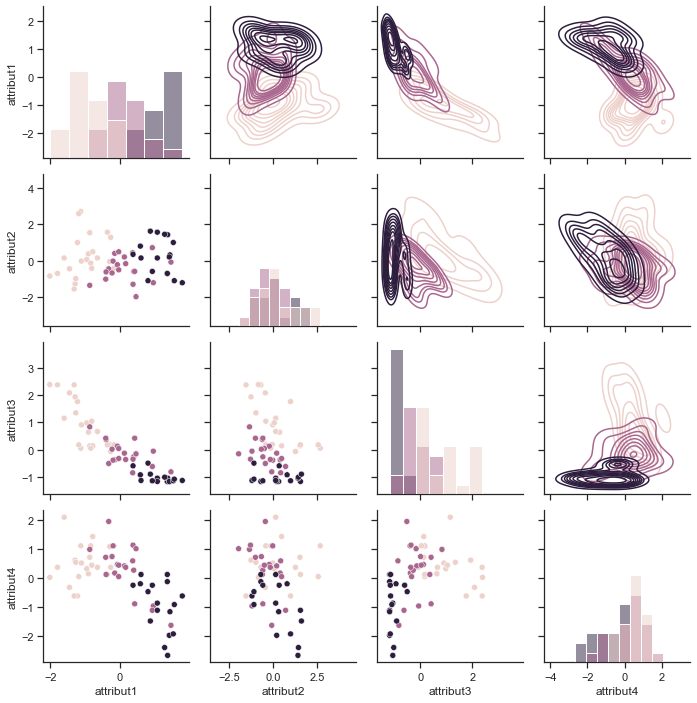

In [8]:
sns.set(style="ticks")


graph2 = sns.PairGrid(normalized_df, hue="classe")
graph2.map_lower(sns.scatterplot)
graph2.map_upper(sns.kdeplot)
graph2.map_diag(sns.histplot)

# graph3 = sns.pairplot(normalized_df, hue="classe", diag_kind="hist", corner=True)
# graph3.map_lower(sns.kdeplot, levels=4, color=".2")   # kde: Kernel Density Estimate


### T-SNE Visualisation

In [10]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

Text(0, 0.5, 'tsne axe 2')

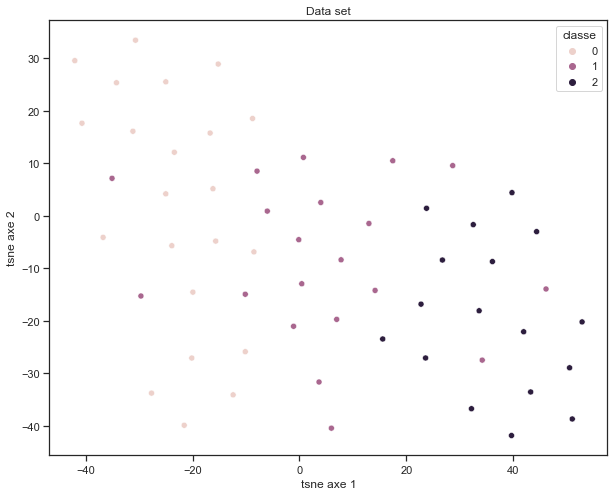

In [11]:
fig, axes = plt.subplots(1, 1,figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1],hue=y)
axes.set_title('Data set')
axes.set_xlabel("tsne axe 1")
axes.set_ylabel("tsne axe 2")

### Corrélation

In [12]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

<AxesSubplot:>

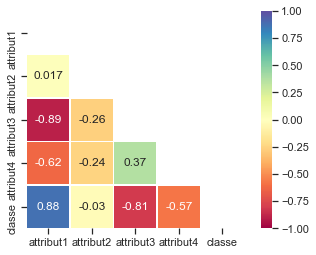

In [13]:
corr_df = normalized_df.corr(method='pearson')
corr_c0_df = normalized_df_c0.corr(method='pearson')
corr_c1_df = normalized_df_c1.corr(method='pearson')
corr_c2_df = normalized_df_c2.corr(method='pearson')


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap='Spectral', vmax=1, vmin=-1, center=0, annot=True,
            square=True, linewidths=.5)


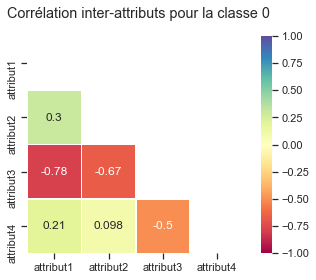

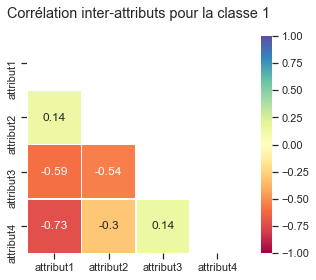

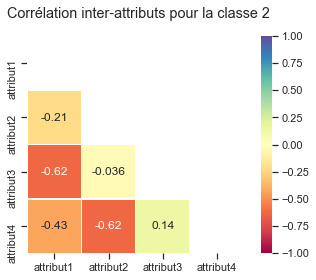

In [14]:
correlations = [corr_c0_df, corr_c1_df, corr_c2_df]
for _index, _corr in enumerate(correlations):
    mask = np.triu(np.ones_like(_corr, dtype=bool))
    plt.figure(_index)
    plt.suptitle("Corrélation inter-attributs pour la classe %i" %_index)
    sns.heatmap(_corr,  mask=mask, vmax=1, vmin=-1, center=0,
            square=True, cmap='Spectral', annot=True, linewidth=0.5)
    plt.show()

## (a)

Suite à la visualisation, ainsi que l'analyse de corrélation de l'ensemble de données, nous constatons qu'il serait favorable de procéder à une analyse des composantes principales.

Effectivement, nous constatons que l'attribut1 ainsi que l'attribut3 semble corrélé peu importe la classe sous analyse.

De plus, nous remarquons que l'_attribut2_ présente une très faible corrélation (proche de 0) par rapport à l'ensemble de classes.  (PAS CERTAIN)

d:\computer science\ift870 - forage de données\travaux pratiques\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


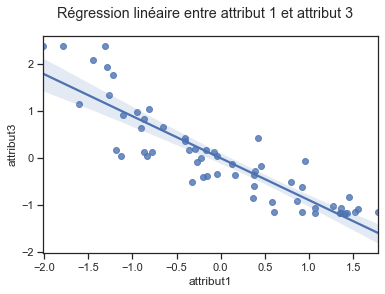

In [15]:
sns.regplot(normalized_df.loc[:, 'attribut1'], normalized_df.loc[:, 'attribut3'])
plt.suptitle("Régression linéaire entre attribut 1 et attribut 3")
plt.show()


### Analyse ACP

In [16]:
pca_full = PCA(n_components=X.shape[1])
pca_full.fit(X)
X_pca_full = pca_full.transform(X)
print("PCA(4) explained variance: ",pca_full.explained_variance_ratio_)

PCA(4) explained variance:  [0.58532927 0.24909152 0.16140426 0.00417495]


On constate que les variables _attribut1_, _attribut2_, _attribut3_ expliquent plus de 99% de la variance.